In [62]:
import os
import shutil
import time
import pandas as pd
import numpy as np
import seaborn as sns
from functools import reduce
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import pyspark.sql.functions as F
from pyspark.mllib.stat import Statistics

In [63]:
from pyspark.sql import SparkSession

In [64]:
spark = SparkSession \
    .builder \
    .appName("Python Spark regression example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [65]:
# load dataset
data = spark.read.csv(path='./data/credit_example.csv',
                      sep=',', encoding='UTF-8', comment=None, header=True, inferSchema=True)

In [66]:
data.limit(5).toPandas()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      247408       0         Cash loans           F            Y   
1      153916       0    Revolving loans           F            Y   
2      229065       0         Cash loans           F            N   
3      282013       0         Cash loans           F            N   
4      142266       0         Cash loans           F            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               N             2          108000.0    172512.0      13477.5   
1               Y             2          135000.0    180000.0       9000.0   
2               Y             0          112500.0    463500.0      20547.0   
3               Y             0          135000.0    549882.0      17739.0   
4               Y             0           90000.0    518562.0      20695.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        0.0                       0.0   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         1.0                        0.0   
3                         0.0                        0.0   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         7.0  
3                        0.0                         1.0  
4                        1.0                         1.0  

[5 rows x 122 columns]

In [56]:
tic = time.time()
nunique = [data.na.drop(subset=[c]).select(c).distinct().count() for c in data.columns]
toc = time.time()
print('CPU time :' + str(toc-tic))

CPU time :91.3736400604248


In [57]:
tic = time.time()
nunique1 =  data.agg(*[F.countDistinct(c) for c in data.columns]).rdd.flatMap(lambda x: x).collect()
toc = time.time()
print('CPU time :' + str(toc-tic))

CPU time :27.83095622062683


In [58]:
nunique1 == nunique

True

In [67]:
tic = time.time()
rate_missing = []
nunique = []
rate_zero = []
rate_variance = []
total = data.count()

[(rate_missing.append(data.filter((F.col(c).isNull()) | (F.trim(F.col(c)) == '')).count() / total),
  rate_variance.append(data.na.drop(subset=[c]).select(c).distinct().count() /
                       data.na.drop(subset=[c]).select(c).count()),
  nunique.append(data.na.drop(subset=[c]).select(c).distinct().count())) for c in data.columns]
d = {'feature': data.columns, 'feature_variance': rate_variance, 'rate_missing': rate_missing, 'nunique': nunique}
toc = time.time()
print('CPU time :' + str(toc-tic))

CPU time :222.40141677856445


In [68]:
identify = pd.DataFrame(d)

In [69]:
identify

feature  feature_variance  rate_missing  nunique
0                    SK_ID_CURR          1.000000        0.0000    10000
1                        TARGET          0.000200        0.0000        2
2            NAME_CONTRACT_TYPE          0.000200        0.0000        2
3                   CODE_GENDER          0.000300        0.0000        3
4                  FLAG_OWN_CAR          0.000200        0.0000        2
5               FLAG_OWN_REALTY          0.000200        0.0000        2
6                  CNT_CHILDREN          0.000700        0.0000        7
7              AMT_INCOME_TOTAL          0.029800        0.0000      298
8                    AMT_CREDIT          0.179600        0.0000     1796
9                   AMT_ANNUITY          0.421542        0.0001     4215
10              AMT_GOODS_PRICE          0.035847        0.0013      358
11              NAME_TYPE_SUITE          0.000703        0.0039        7
12             NAME_INCOME_TYPE          0.000400        0.0000        4
13          NAME_EDUCATION_TYPE          0.000500        0.0000        5
14           NAME_FAMILY_STATUS          0.000500        0.0000        5
15            NAME_HOUSING_TYPE          0.000600        0.0000        6
16   REGION_POPULATION_RELATIVE          0.008000        0.0000       80
17                   DAYS_BIRTH          0.743400        0.0000     7434
18                DAYS_EMPLOYED          0.421000        0.0000     4210
19            DAYS_REGISTRATION          0.659300        0.0000     6593
20              DAYS_ID_PUBLISH          0.439900        0.0000     4399
21                  OWN_CAR_AGE          0.013368        0.6559       46
22                   FLAG_MOBIL          0.000100        0.0000        1
23               FLAG_EMP_PHONE          0.000200        0.0000        2
24              FLAG_WORK_PHONE          0.000200        0.0000        2
25             FLAG_CONT_MOBILE          0.000200        0.0000        2
26                   FLAG_PHONE          0.000200        0.0000        2
27                   FLAG_EMAIL          0.000200        0.0000        2
28              OCCUPATION_TYPE          0.002624        0.3140       18
29              CNT_FAM_MEMBERS          0.000800        0.0000        8
..                          ...               ...           ...      ...
92     DEF_30_CNT_SOCIAL_CIRCLE          0.000603        0.0045        6
93     OBS_60_CNT_SOCIAL_CIRCLE          0.002109        0.0045       21
94     DEF_60_CNT_SOCIAL_CIRCLE          0.000603        0.0045        6
95       DAYS_LAST_PHONE_CHANGE          0.265600        0.0000     2656
96              FLAG_DOCUMENT_2          0.000200        0.0000        2
97              FLAG_DOCUMENT_3          0.000200        0.0000        2
98              FLAG_DOCUMENT_4          0.000200        0.0000        2
99              FLAG_DOCUMENT_5          0.000200        0.0000        2
100             FLAG_DOCUMENT_6          0.000200        0.0000        2
101             FLAG_DOCUMENT_7          0.000200        0.0000        2
102             FLAG_DOCUMENT_8          0.000200        0.0000        2
103             FLAG_DOCUMENT_9          0.000200        0.0000        2
104            FLAG_DOCUMENT_10          0.000100        0.0000        1
105            FLAG_DOCUMENT_11          0.000200        0.0000        2
106            FLAG_DOCUMENT_12          0.000100        0.0000        1
107            FLAG_DOCUMENT_13          0.000200        0.0000        2
108            FLAG_DOCUMENT_14          0.000200        0.0000        2
109            FLAG_DOCUMENT_15          0.000200        0.0000        2
110            FLAG_DOCUMENT_16          0.000200        0.0000        2
111            FLAG_DOCUMENT_17          0.000100        0.0000        1
112            FLAG_DOCUMENT_18          0.000200        0.0000        2
113            FLAG_DOCUMENT_19          0.000200        0.0000        2
114            FLAG_DOCUMENT_20          0.000200        0.0000        2
115      

In [70]:
missing_thold = 0.68
variance_thold = 0
drop = identify[(identify['feature_variance'] < variance_thold)|(identify['rate_missing'] > missing_thold)|(identify['nunique']==1)]['feature']

In [71]:
drop

22                   FLAG_MOBIL
48               COMMONAREA_AVG
54         LIVINGAPARTMENTS_AVG
56      NONLIVINGAPARTMENTS_AVG
62              COMMONAREA_MODE
68        LIVINGAPARTMENTS_MODE
70     NONLIVINGAPARTMENTS_MODE
76              COMMONAREA_MEDI
82        LIVINGAPARTMENTS_MEDI
84     NONLIVINGAPARTMENTS_MEDI
86           FONDKAPREMONT_MODE
104            FLAG_DOCUMENT_10
106            FLAG_DOCUMENT_12
111            FLAG_DOCUMENT_17
Name: feature, dtype: object

In [72]:
len(data.columns)

122

In [73]:
len(set(data.columns) - set(drop))

108

In [74]:
set([c for c in data.columns if c not in list(drop) ]) == set(data.columns) - set(drop)

True

In [75]:
import os
import shutil
import time
import pandas as pd
import numpy as np
import seaborn as sns
from functools import reduce
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import pyspark.sql.functions as F
from pyspark.mllib.stat import Statistics

from pyspark.mllib.stat import Statistics

def mkdir(path):
    """
    Make a new directory. if it's exist, keep the old files.
    :param path: the directory path
    """
    try:
        os.mkdir(path)
    except OSError:
        pass


def mkdir_clean(path):
    """
    Make a new directory. if it's exist, remove the old files.
    :param path: the directory path
    """
    try:
        os.mkdir(path)
    except OSError:
        try:
            if len(os.listdir(path)) != 0:
                shutil.rmtree(path)
                os.mkdir(path)
        except Exception as e:
            print(e)

            
def data_types(df_in, tracking=False):
    """
    Generate the data types of the rdd data frame.
    :param df_in: the input rdd data frame
    :param tracking: the flag for displaying CPU time, the default value is False
    :return: data types pandas data frame
    >>> test = spark.createDataFrame([
                        ('Joe', 67, 'F', 7000, 'asymptomatic', 286.1, '2019-6-28'),
                        ('Henry', 67, 'M', 8000, 'asymptomatic', 229.2, '2019-6-29'),
                        ('Sam', 37,  'F', 6000, 'nonanginal', 250.3, '2019-6-30'),
                        ('Max', 56, 'M', 9000, 'nontypical', 236.4, '2019-5-28'),
                        ('Mat', 56, 'F', 9000, 'asymptomatic', 254.5, '2019-4-28')],
                        ['Name', 'Age', 'Sex', 'Salary', 'ChestPain', 'Chol', 'CreatDate']
                       )
    >>> test = test.withColumn('CreatDate', F.col('CreatDate').cast('timestamp'))
    >>> from PySparkAudit import data_types
    >>> data_types(test)
         feature     dtypes
    0       Name     string
    1        Age     bigint
    2        Sex     string
    3     Salary     bigint
    4  ChestPain     string
    5       Chol     double
    6  CreatDate  timestamp
    """
    if tracking:
        print('================================================================')
        print("Collecting data types.... Please be patient!")
        start = time.time()

    d_types = pd.DataFrame(df_in.dtypes, columns=['feature', 'dtypes'])

    if tracking:
        end = time.time()
        print('Generate counts took = ' + str(end - start) + ' s')

    return d_types

def dtypes_class(df_in):
    """
    Generate the data type categories: numerical, categorical, date and unsupported category.
    :param df_in: the input rdd data frame
    :return: data type categories
    >>> test = spark.createDataFrame([
                        ('Joe', 67, 'F', 7000, 'asymptomatic', 286.1, '2019-6-28'),
                        ('Henry', 67, 'M', 8000, 'asymptomatic', 229.2, '2019-6-29'),
                        ('Sam', 37,  'F', 6000, 'nonanginal', 250.3, '2019-6-30'),
                        ('Max', 56, 'M', 9000, 'nontypical', 236.4, '2019-5-28'),
                        ('Mat', 56, 'F', 9000, 'asymptomatic', 254.5, '2019-4-28')],
                        ['Name', 'Age', 'Sex', 'Salary', 'ChestPain', 'Chol', 'CreatDate']
                       )
    >>> test = test.withColumn('CreatDate', F.col('CreatDate').cast('timestamp'))
    >>> from PySparkAudit import dtypes_class
    >>> dtypes_class(test)
    (     feature       DataType
    0       Name     StringType
    1        Age       LongType
    2        Sex     StringType
    3    Salary       LongType
    4  ChestPain     StringType
    5       Chol     DoubleType
    6  CreatDate  TimestampType,
    ['Age', 'Salary', 'Chol'],
    ['Name', 'Sex', 'ChestPain'],
    ['CreatDate'], [])
    """
    # __all__ = [
    # "DataType", "NullType", "StringType", "BinaryType", "BooleanType", "DateType",
    # "TimestampType", "DecimalType", "DoubleType", "FloatType", "ByteType", "IntegerType",
    # "LongType", "ShortType", "ArrayType", "MapType", "StructField", "StructType"]

    # numerical data types in rdd DataFrame dtypes
    num_types = ['DecimalType', 'DoubleType', 'FloatType', 'ByteType', 'IntegerType', 'LongType', 'ShortType']
    # qualitative data types in rdd DataFrame dtypes
    cat_types = ['NullType', 'StringType', 'BinaryType', 'BooleanType']
    # date data types in rdd DataFrame dtypes
    date_types = ['DateType', 'TimestampType']
    # unsupported data types in rdd DataFrame dtypes
    unsupported_types = ['ArrayType', 'MapType', 'StructField', 'StructType']

    all_fields = [(f.name, str(f.dataType)) for f in df_in.schema.fields]

    all_df = pd.DataFrame(all_fields, columns=['feature', 'DataType'])

    # initialize the memory for the corresponding fields
    num_fields = []
    cat_fields = []
    date_fields = []
    unsupported_fields = []

    [num_fields.append(item[0]) if item[1] in num_types else
     cat_fields.append(item[0]) if item[1] in cat_types else
     date_fields.append(item[0]) if item[1] in date_types else
     unsupported_fields.append(item[0]) for item in all_fields]

    return all_df, num_fields, cat_fields, date_fields, unsupported_fields

def rates(df_in, columns=None, numeric=True, tracking=False):
    """
    Generate the null, empty, negative, zero and  positive value rates and feature variance for
    each feature in the rdd data frame.
    :param df_in: the input rdd data frame
    :param columns: the specific feature columns, the default value is None
    :param numeric: the flag for numerical rdd data frame, the default value is True
    :param tracking: the flag for displaying CPU time, the default value is False
    :return: the null, empty, negative, zero and  positive value rates and feature variance
             in pandas data frame
    >>> test = spark.createDataFrame([
                        ('Joe', 67, 'F', 7000, 'asymptomatic', 286.1, '2019-6-28'),
                        ('Henry', 67, 'M', 8000, 'asymptomatic', 229.2, '2019-6-29'),
                        ('Sam', 37,  'F', 6000, 'nonanginal', 250.3, '2019-6-30'),
                        ('Max', 56, 'M', 9000, 'nontypical', 236.4, '2019-5-28'),
                        ('Mat', 56, 'F', 9000, 'asymptomatic', 254.5, '2019-4-28')],
                        ['Name', 'Age', 'Sex', 'Salary', 'ChestPain', 'Chol', 'CreatDate']
                       )
    >>> from PySparkAudit import rates
    >>> rates(test)
         feature  feature_variance    ...     rate_zero  rate_pos
    0        Age               0.6    ...           0.0       1.0
    1     Salary               0.8    ...           0.0       1.0
    2       Chol               1.0    ...           0.0       1.0
    3       Name               1.0    ...           0.0       0.0
    4        Sex               0.4    ...           0.0       0.0
    5  ChestPain               0.6    ...           0.0       0.0
    6  CreatDate               1.0    ...           0.0       0.0
    [7 rows x 7 columns]
    """
    if tracking:
        print('================================================================')
        print('Calculating rates.... Please be patient!')

    if columns is None:
        _, num_fields, cat_fields, _, _ = dtypes_class(df_in)
        columns = num_fields + cat_fields

    start = time.time()
    rate_null = []
    rate_empty = []
    rate_pos = []
    rate_neg = []
    rate_zero = []
    rate_variance = []

    data = df_in.select(columns)
    total = data.count()

    if numeric:
        [(rate_null.append(data.filter(F.col(c).isNull()).count() / total),
          rate_empty.append(data.filter(F.trim(F.col(c)) == '').count() / total),
          rate_pos.append(data.filter(F.col(c) > 0).count() / total),
          rate_neg.append(data.filter(F.col(c) < 0).count() / total),
          rate_zero.append(data.filter(F.col(c) == 0).count() / total),
          rate_variance.append(data.na.drop(subset=[c]).select(c).distinct().count() /
                               data.na.drop(subset=[c]).select(c).count())) for c in data.columns]

        d = {'feature': columns, 'feature_variance': rate_variance, 'rate_null': rate_null,
             'rate_empty': rate_empty, 'rate_neg': rate_neg, 'rate_zero': rate_zero,
             'rate_pos': rate_pos}
    else:
        [(rate_null.append(data.filter(F.col(c).isNull()).count() / total),
          rate_empty.append(data.filter(F.trim(F.col(c)) == '').count() / total),
          rate_variance.append(data.na.drop(subset=[c]).select(c).distinct().count() /
                               data.na.drop(subset=[c]).select(c).count())) for c in data.columns]

        d = {'feature': columns, 'feature_variance': rate_variance, 'rate_null': rate_null,
             'rate_empty': rate_empty}

    if tracking:
        end = time.time()
        print('Generate rates took: ' + str(end - start) + ' s')

    return pd.DataFrame(d)

def corr_matrix(df_in, method="pearson", output_dir=None, rotation=True, display=False, tracking=False):
    """
    Generate the correlation matrix and heat map plot for rdd data frame.
    :param df_in: the input rdd data frame
    :param method: the method which applied to calculate the correlation matrix: pearson or spearman.
                the default value is pearson
    :param output_dir: the out put directory, the default value is the current working directory
    :param rotation: the flag for rotating the xticks in the plot, the default value is True
    :param display: the flag for displaying the figures, the default value is False
    :param tracking: the flag for displaying CPU time, the default value is False
    :return: the correlation matrix in pandas data frame
    
    >>> test = spark.createDataFrame([
                        ('Joe', 67, 'F', 7000, 'asymptomatic', 286.1, '2019-6-28'),
                        ('Henry', 67, 'M', 8000, 'asymptomatic', 229.2, '2019-6-29'),
                        ('Sam', 37,  'F', 6000, 'nonanginal', 250.3, '2019-6-30'),
                        ('Max', 56, 'M', 9000, 'nontypical', 236.4, '2019-5-28'),
                        ('Mat', 56, 'F', 9000, 'asymptomatic', 254.5, '2019-4-28')],
                        ['Name', 'Age', 'Sex', 'Salary', 'ChestPain', 'Chol', 'CreatDate']
                       )
    >>> from PySparkAudit import corr_matrix
    >>> corr_matrix(test)
    ================================================================
    The correlation matrix plot Corr.png was located at:
    /home/feng/Audited
                  Age   Salary      Chol
    Age      1.000000  0.431663  0.147226
    Salary   0.431663  1.000000 -0.388171
    Chol     0.147226 -0.388171  1.000000
    """
    _, num_fields, _, _, _ = dtypes_class(df_in)

    if len(num_fields) > 1:
        df_in = df_in.select(num_fields).na.drop()

        if output_dir is None:
            out_path = os.getcwd() + '/Audited'
        else:
            out_path = output_dir + '/Audited'
        mkdir(out_path)

        print('================================================================')
        print('The correlation matrix plot Corr.png was located at:')
        print(out_path)
        if tracking:
            print('Calculating correlation matrix... Please be patient!')
            start = time.time()

        # convert the rdd data data frame to dense matrix
        col_names = df_in.columns
        features = df_in.rdd.map(lambda row: row[0:])

        # calculate the correlation matrix
        corr_mat = Statistics.corr(features, method=method)
        corr = pd.DataFrame(corr_mat)
        corr.index, corr.columns = col_names, col_names

        # corr.to_csv('{}/corr_mat.csv'.format(out_path))

        fig = plt.figure(figsize=(20, 15))  # Push new figure on stack
        sns_plot = sns.heatmap(corr, cmap="YlGnBu",
                               xticklabels=corr.columns.values,
                               yticklabels=corr.columns.values)
        if rotation:
            plt.xticks(rotation=90, fontsize=20)
            sns_plot.set_yticklabels(sns_plot.get_yticklabels(), rotation=0, fontsize=20)
        plt.savefig("{}/01-correlation_mat.png".format(out_path))
        if display:
            plt.show()
        plt.clf()
        plt.close(fig)
        if tracking:
            end = time.time()
            print('Generate correlation matrix took = ' + str(end - start) + ' s')

        return corr

In [76]:
toc = time.time()
print('CPU time :' + str(toc-tic))

CPU time :222.55329513549805


In [77]:
def corr_selector(data, corr_thold = 0.9, method="pearson", keep_binary = False):
    
    _, num_fields, _, _, _ = dtypes_class(data)
    
    if len(num_fields) > 1:
        df_in = data.select(num_fields).na.drop()
        
    # convert the rdd data data frame to dense matrix
    col_names = df_in.columns
    features = df_in.rdd.map(lambda row: row[0:])

    # calculate the correlation matrix
    corr_mat = Statistics.corr(features, method=method)
    corr = pd.DataFrame(corr_mat)
    corr.index, corr.columns = col_names, col_names
    
    upper = corr.where(np.triu(np.ones(corr.shape), k = 1).astype(np.bool))
    
    corr_drop = [column for column in upper.columns if any(upper[column].abs() > corr_thold)]
    
    return corr_drop

In [78]:
corr_selector(data)

['AMT_GOODS_PRICE',
 'FLAG_EMP_PHONE',
 'REGION_RATING_CLIENT_W_CITY',
 'YEARS_BUILD_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'TOTALAREA_MODE',
 'OBS_60_CNT_SOCIAL_CIRCLE']

In [79]:
cat_num = 2
corr_thold = 0.99
method="pearson"

# numerical data types in rdd DataFrame dtypes
num_types = ['DecimalType', 'DoubleType', 'FloatType', 
             'ByteType', 'IntegerType', 'LongType', 'ShortType']

num_fields = [f.name for f in data.schema.fields if str(f.dataType) in num_types]

#[data.na.drop(subset=[c]).select(c).distinct().count() for c in data.columns]
nunique = data.agg(*[F.countDistinct(c) for c in data.columns]).rdd.flatMap(lambda x: x).collect()


flag = list(np.array(data.columns)[np.array(nunique) <= cat_num])

num_cols = [col for col in num_fields if col not in flag]

if len(num_cols) > 1:
    df_in = data.select(num_cols).na.drop()
else:
    exit(0)
    print("Only has one numerical feature!!! Don't need correlation selector.")

# convert the rdd data data frame to dense matrix
col_names = df_in.columns
features = df_in.rdd.map(lambda row: row[0:])

# calculate the correlation matrix
corr_mat = Statistics.corr(features, method=method)
corr = pd.DataFrame(corr_mat)
corr.index, corr.columns = col_names, col_names

upper = corr.where(np.triu(np.ones(corr.shape), k = 1).astype(np.bool))

corr_drop = [column for column in upper.columns if any(upper[column].abs() > corr_thold)]

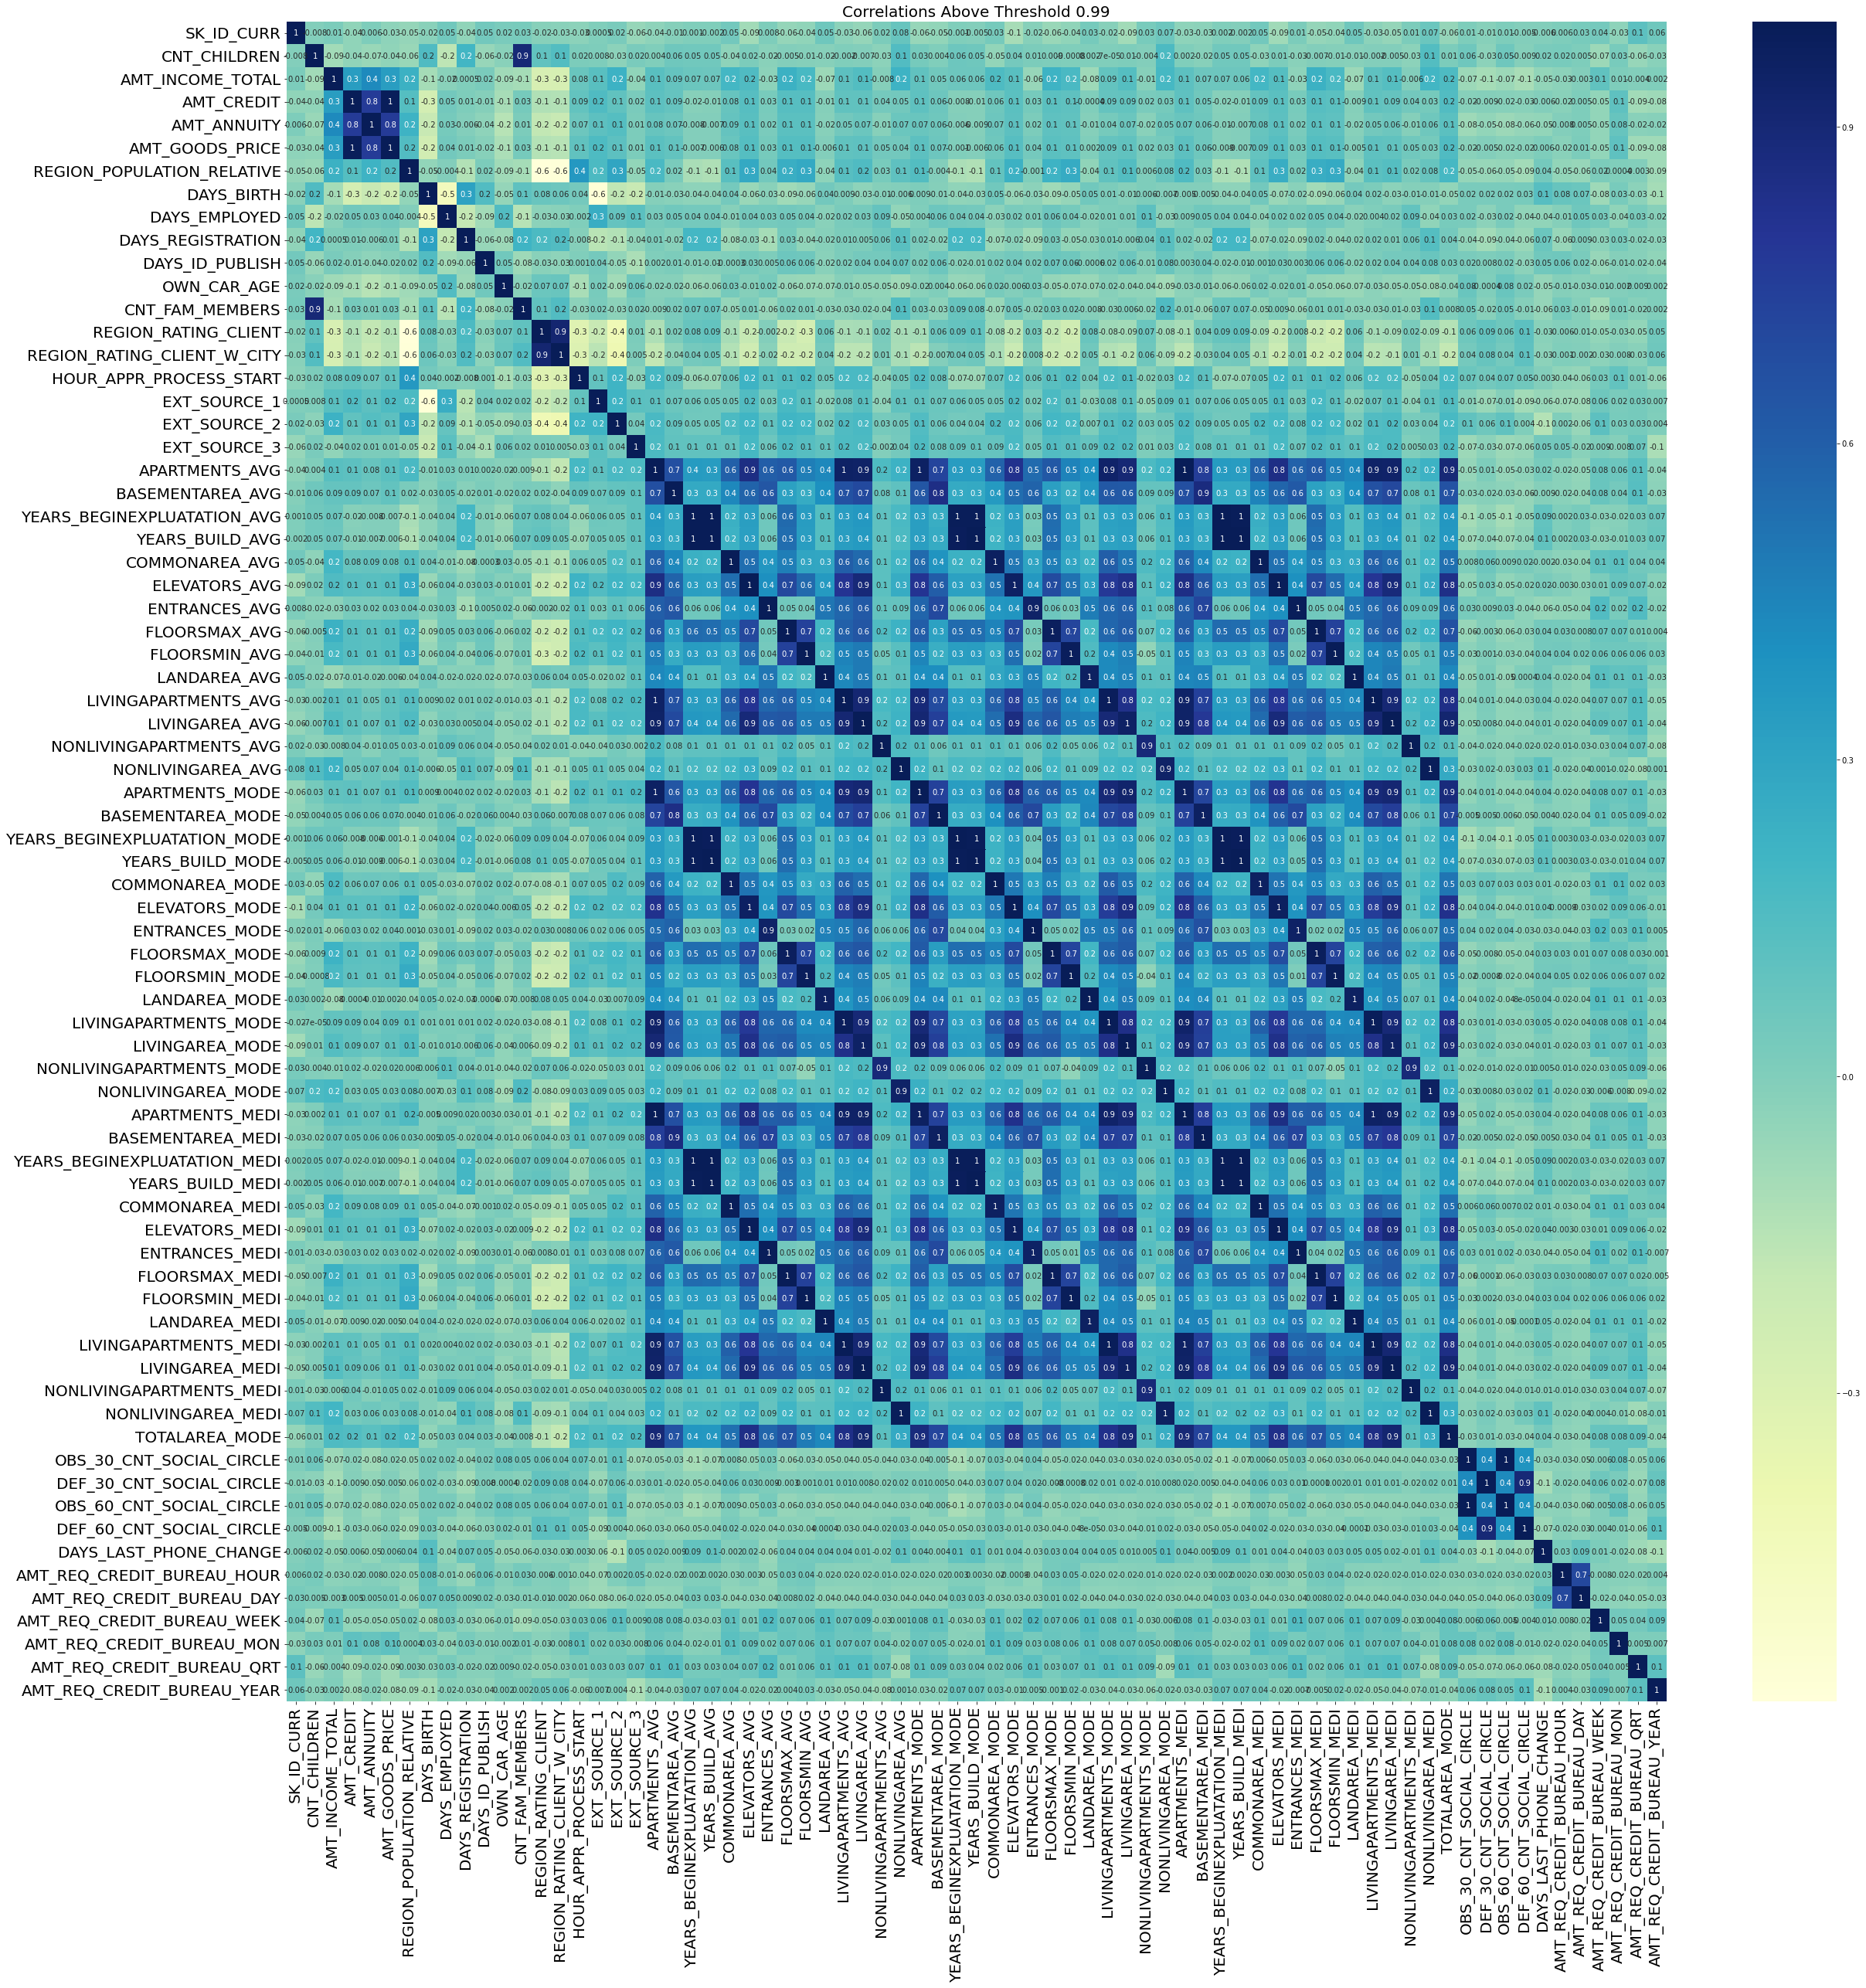

In [80]:
fig = plt.figure(figsize=(40, 40))  # Push new figure on stack
sns_plot = sns.heatmap(corr, cmap="YlGnBu",
                       xticklabels=corr.columns.values,
                       yticklabels=corr.columns.values,  annot=True, fmt=".1g")
plt.title("Correlations Above Threshold {}".format(corr_thold), fontsize =20)

plt.xticks(rotation=90, fontsize=20)
sns_plot.set_yticklabels(sns_plot.get_yticklabels(), rotation=0, fontsize=20)
plt.show()

In [319]:
sns.set(font_scale=1.0)

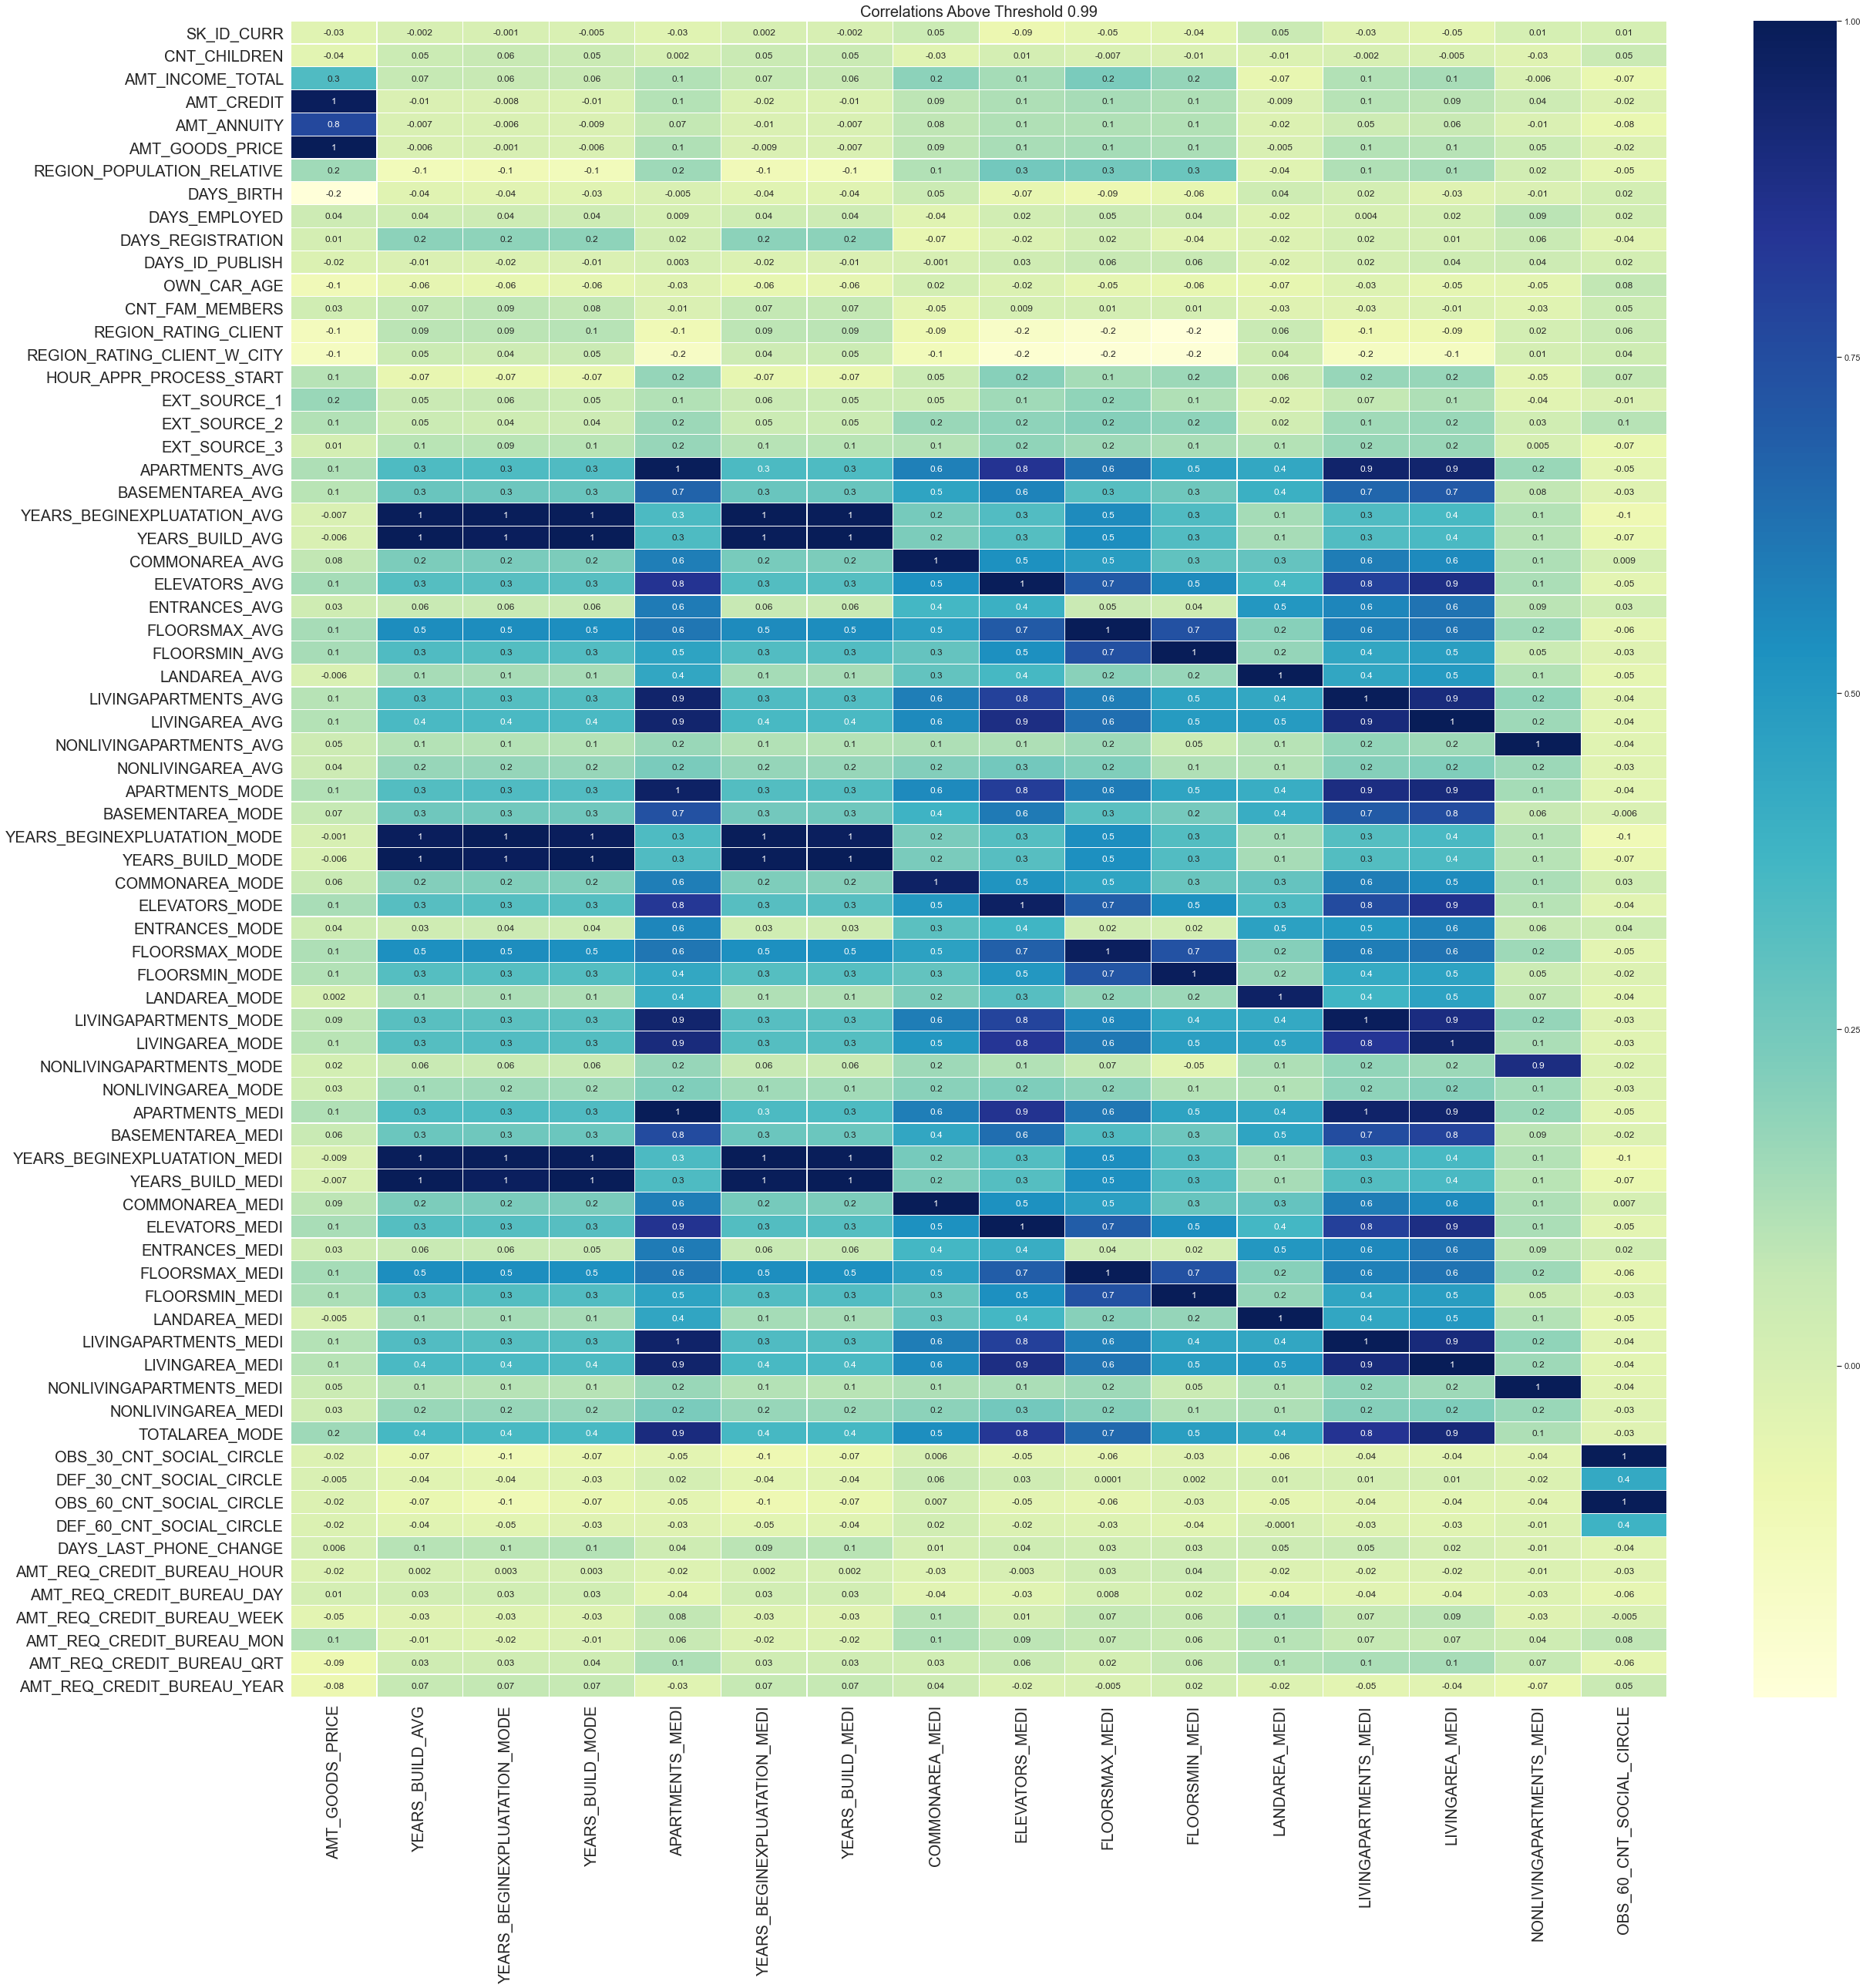

In [325]:
dropped = corr[corr_drop]
#dropped = dropped[dropped.index.isin(corr_drop)]

fig = plt.figure(figsize=(40, 40))  # Push new figure on stack
sns_plot = sns.heatmap(dropped, cmap="YlGnBu",
                       xticklabels=dropped.columns.values,
                       yticklabels=corr.columns.values,  
                       annot=True, fmt=".1g", linewidths=.25)
plt.title("Correlations Above Threshold {}".format(corr_thold), fontsize =20)

plt.xticks(rotation=90, fontsize=20)
sns_plot.set_yticklabels(sns_plot.get_yticklabels(), rotation=0, fontsize=20)
plt.show()

In [360]:
# qualitative data types in rdd DataFrame dtypes
cat_types = ['NullType', 'StringType', 'BinaryType', 'BooleanType']

cat_fields = [f.name for f in data.schema.fields if str(f.dataType) in cat_types]

In [362]:
data.select(cat_fields).limit(4).toPandas()

NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY NAME_TYPE_SUITE  \
0         Cash loans           F            Y               N   Unaccompanied   
1    Revolving loans           F            Y               Y   Unaccompanied   
2         Cash loans           F            N               Y          Family   
3         Cash loans           F            N               Y   Unaccompanied   

  NAME_INCOME_TYPE            NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
0          Working  Secondary / secondary special               Married   
1          Working  Secondary / secondary special        Civil marriage   
2        Pensioner  Secondary / secondary special                 Widow   
3        Pensioner  Secondary / secondary special  Single / not married   

   NAME_HOUSING_TYPE OCCUPATION_TYPE WEEKDAY_APPR_PROCESS_START  \
0  House / apartment        Laborers                    TUESDAY   
1  House / apartment   Cooking staff                    TUESDAY   
2  House / apartment            None                   THURSDAY   
3  House / apartment            None                  WEDNESDAY   

        ORGANIZATION_TYPE FONDKAPREMONT_MODE  HOUSETYPE_MODE  \
0  Business Entity Type 3   reg oper account  block of flats   
1              Restaurant               None            None   
2                     XNA               None            None   
3                     XNA   reg oper account  block of flats   

  WALLSMATERIAL_MODE EMERGENCYSTATE_MODE  
0       Stone, brick                  No  
1               None                None  
2               None                None  
3       Stone, brick                  No

In [59]:
import os
import shutil
import time
import pandas as pd
import numpy as np
import seaborn as sns
from functools import reduce
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import pyspark.sql.functions as F
from pyspark.mllib.stat import Statistics

class AutoFeatures():
    """
    Auto feature selector for Machine Learning Modeling with PySpark.
    """
    
    def __init__(self):
        
        self.missing_drop = None
        self.unique_drop = None
        self.corr_drop = None
        
        self.keep = {}


    def unique_selector(self, data):
        
        nunique = data.agg(*[F.countDistinct(c) for c in data.columns]).rdd.flatMap(lambda x: x).collect()
        #[data.na.drop(subset=[c]).select(c).distinct().count() for c in data.columns]
        
        self.unique_drop = list(np.array(data.columns)[np.array(nunique) == 1])
        
    def missing_selector(self, data, missing_thold=0.6, display=False, tracking=False):

        if tracking:
            start = time.time()
            
        self.missing_thold = missing_thold
        self.total = data.count()

        rate_missing = [data.filter((F.col(c).isNull())|(F.trim(F.col(c)) == '')).count()/self.total 
                        for c in data.columns]

        #self.rate_missing = rate_missing
        self.missing_drop = list(np.array(data.columns)[np.array(rate_missing) > missing_thold])
                
        if tracking:
            end = time.time()
            print('Missing selector took = ' + str(end - start) + ' s')     
            
        if display:
            plt.figure(figsize=(10,8))
            sns.distplot(Fs.rate_missing, bins=50, kde=False, rug=True, color='blue');
            plt.show()
            
    def corr_selector(self, data, corr_thold = 0.9, method="pearson", rotation=True, 
                            display=False, tracking=False, cat_num = 2):
        
        if tracking:
            start = time.time()
        
        # numerical data types in rdd DataFrame dtypes
        num_types = ['DecimalType', 'DoubleType', 'FloatType', 
                     'ByteType', 'IntegerType', 'LongType', 'ShortType']
        #
        num_fields = [f.name for f in data.schema.fields if str(f.dataType) in num_types]
        
        nunique = data.agg(*[F.countDistinct(c) for c in data.columns]).rdd.flatMap(lambda x: x).collect()
        #[data.na.drop(subset=[c]).select(c).distinct().count() for c in data.columns]
        
        flag = list(np.array(data.columns)[np.array(nunique) <= cat_num])

        num_cols = [col for col in num_fields if col not in flag]

        if len(num_cols) > 1:
            df_in = data.select(num_cols).na.drop()
        else:
            exit(0)
            print("Only has one numerical feature!!! Don't need correlation selector.")

        # convert the rdd data data frame to dense matrix
        col_names = df_in.columns
        features = df_in.rdd.map(lambda row: row[0:])

        # calculate the correlation matrix
        corr_mat = Statistics.corr(features, method=method)
        corr = pd.DataFrame(corr_mat)
        corr.index, corr.columns = col_names, col_names

        upper = corr.where(np.triu(np.ones(corr.shape), k = 1).astype(np.bool))

        corr_drop = [column for column in upper.columns if any(upper[column].abs() > corr_thold)]
        
        self.corr_drop = corr_drop
        
        if tracking:
            end = time.time()
            print('correlation selector took = ' + str(end - start) + ' s')     
        
        dropped = corr[corr_drop]
        
        if display:
            fig = plt.figure(figsize=(40, 40))  # Push new figure on stack
            sns_plot = sns.heatmap(dropped, cmap="YlGnBu",
                                   xticklabels=dropped.columns.values,
                                   yticklabels=corr.columns.values, 
                                   annot=True, fmt=".1g", linewidths=.25)
            plt.xlabel('Features to Drop', size = 20)
            plt.ylabel('All Numerical Features', size = 20)
            plt.title("Correlations Above Threshold {}".format(corr_thold), fontsize =20)
            if rotation:
                plt.xticks(rotation=90, fontsize=20)
                sns_plot.set_yticklabels(sns_plot.get_yticklabels(), rotation=0, fontsize=20)
            plt.show()              

In [81]:
Fs = AutoFeatures()

In [82]:
identify[(identify['nunique']==1)]['feature']

22           FLAG_MOBIL
104    FLAG_DOCUMENT_10
106    FLAG_DOCUMENT_12
111    FLAG_DOCUMENT_17
Name: feature, dtype: object

In [83]:
Fs.unique_selector(data)

In [84]:
Fs.unique_drop

['FLAG_MOBIL', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_17']

In [85]:
identify[identify['rate_missing'] > missing_thold]['feature']

48              COMMONAREA_AVG
54        LIVINGAPARTMENTS_AVG
56     NONLIVINGAPARTMENTS_AVG
62             COMMONAREA_MODE
68       LIVINGAPARTMENTS_MODE
70    NONLIVINGAPARTMENTS_MODE
76             COMMONAREA_MEDI
82       LIVINGAPARTMENTS_MEDI
84    NONLIVINGAPARTMENTS_MEDI
86          FONDKAPREMONT_MODE
Name: feature, dtype: object

In [ ]:
Fs.missing_selector(data, missing_thold = 0.68, display = True, tracking= True)

In [87]:
Fs.missing_drop

['COMMONAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'COMMONAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'COMMONAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'FONDKAPREMONT_MODE']

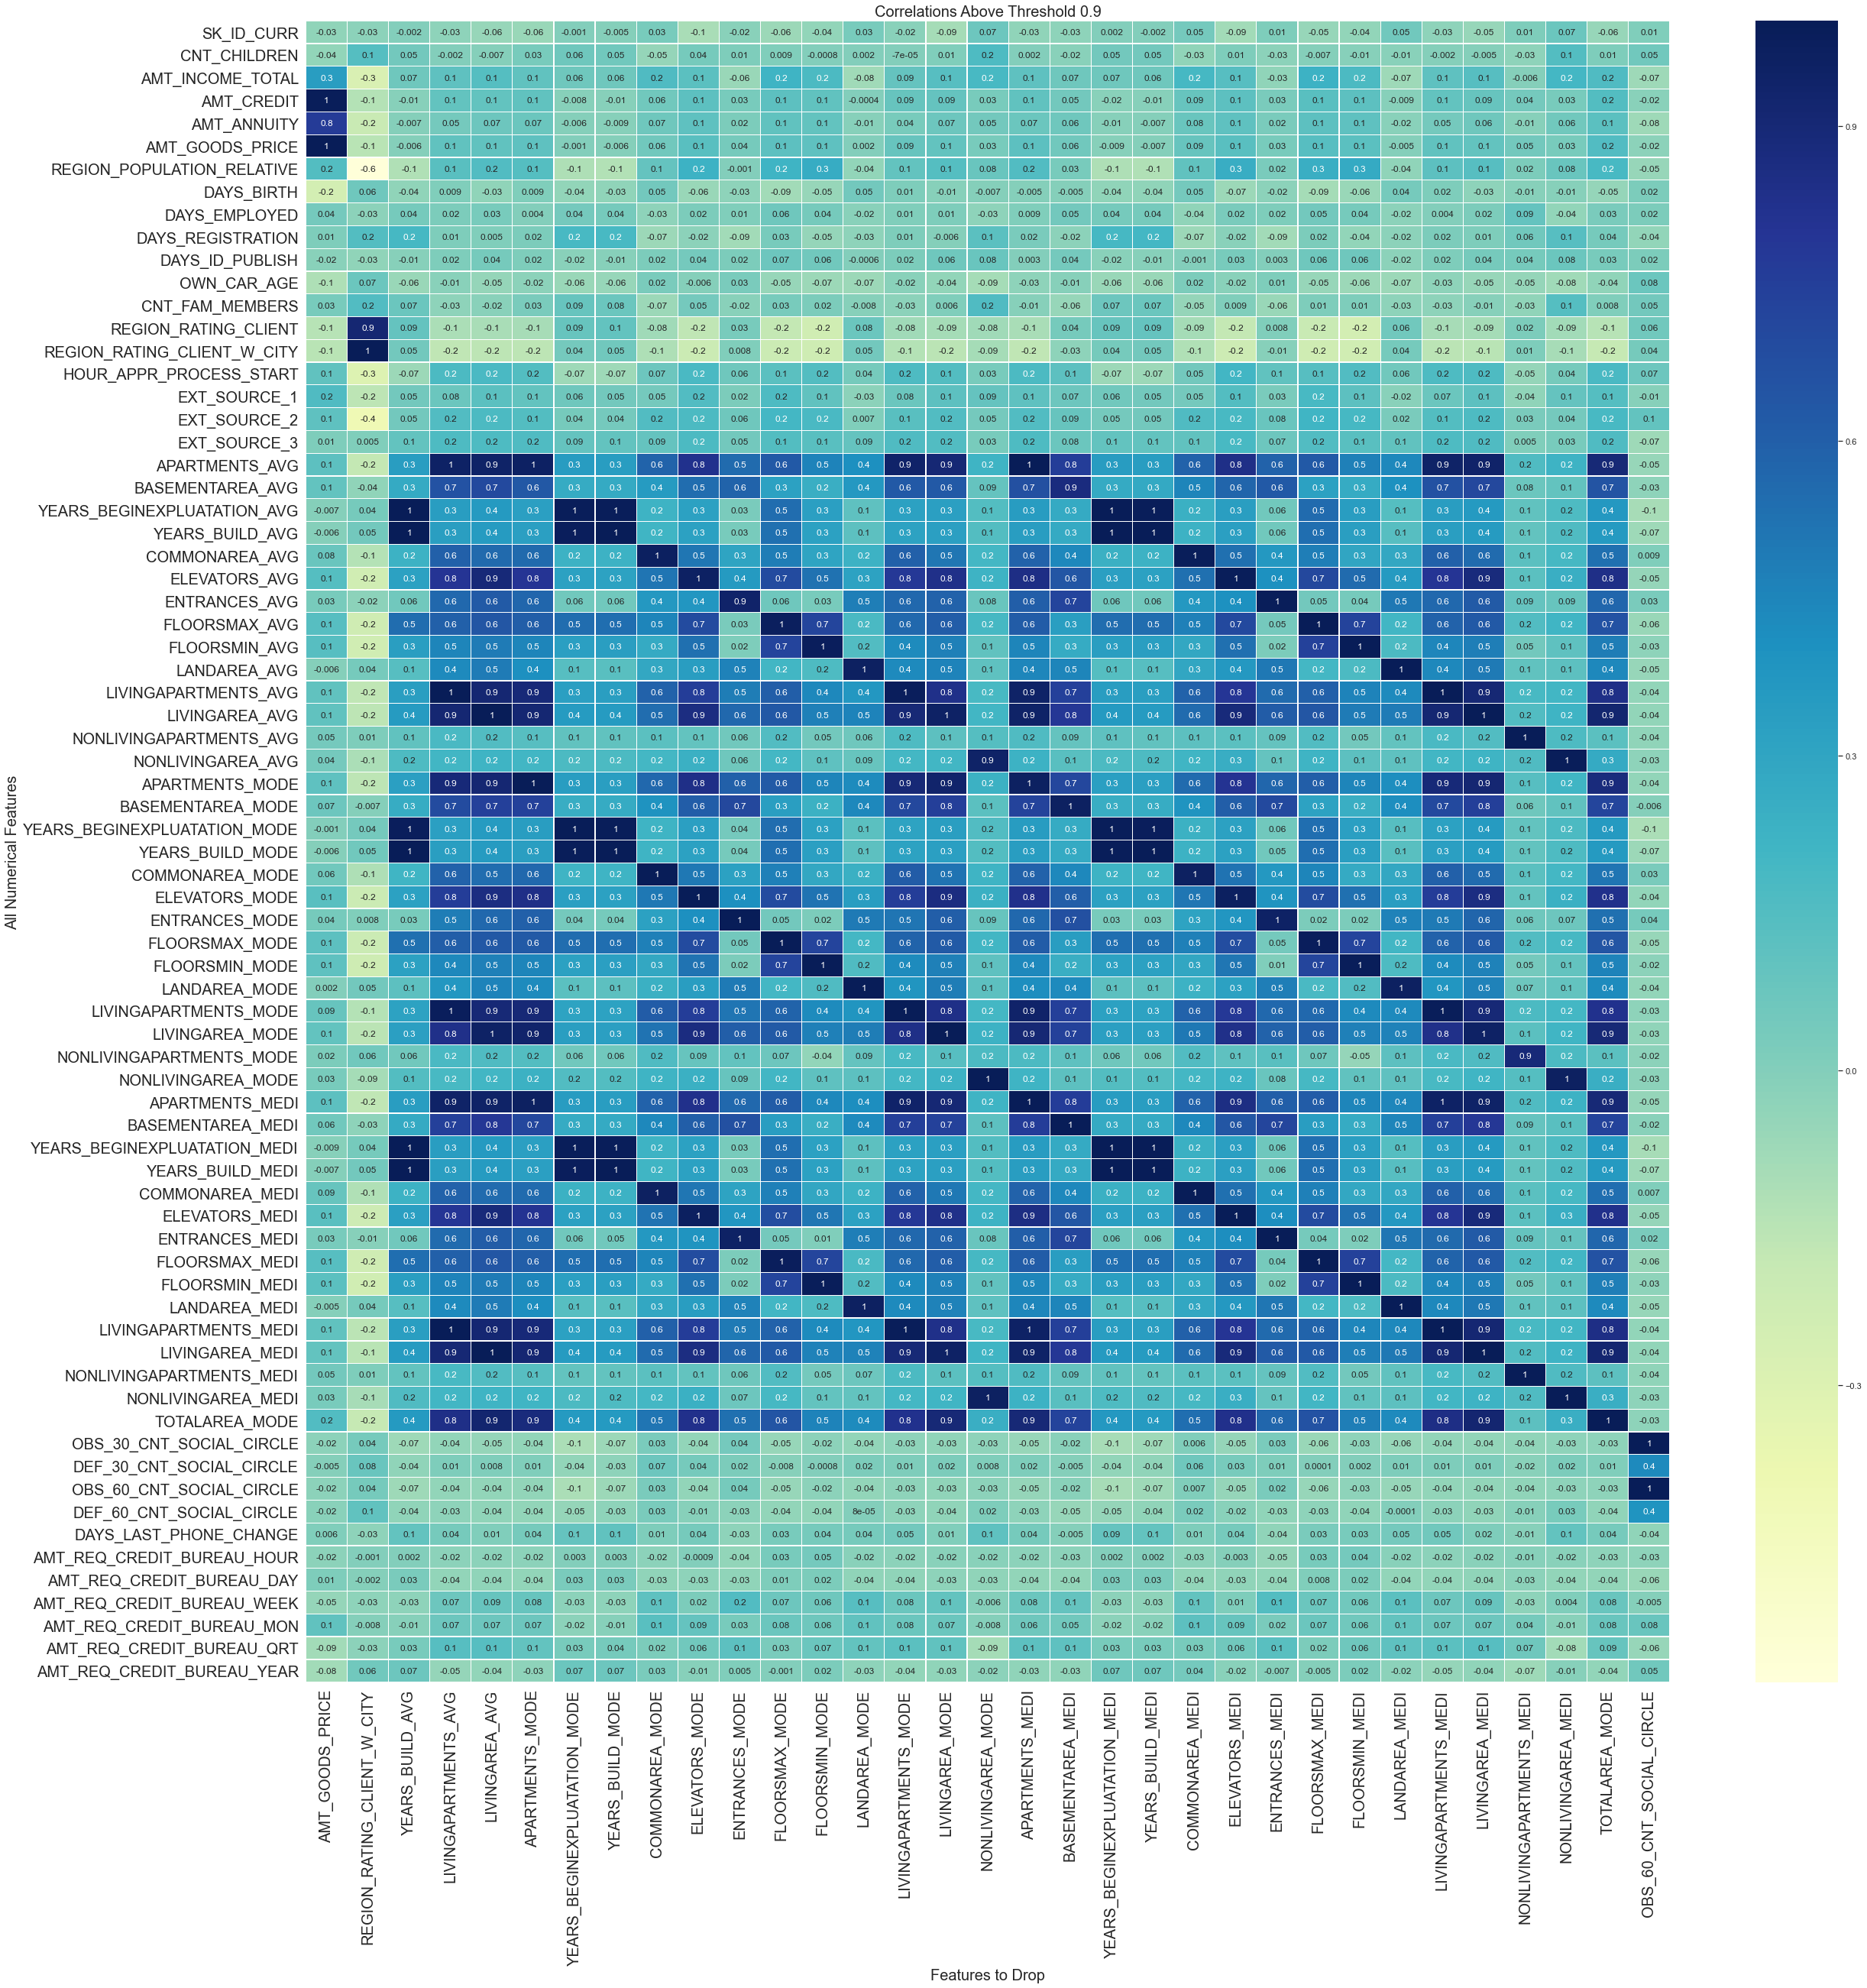

In [342]:
Fs.corr_selector(data, display=True)

In [343]:
Fs.corr_drop

['AMT_GOODS_PRICE',
 'REGION_RATING_CLIENT_W_CITY',
 'YEARS_BUILD_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'TOTALAREA_MODE',
 'OBS_60_CNT_SOCIAL_CIRCLE']

In [347]:
all_drop = Fs.corr_drop+ Fs.unique_drop+Fs.missing_drop

In [355]:
len(all_drop)

47

In [354]:
len(list(dict.fromkeys(all_drop)))

41